### ライブラリ

In [32]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import utils
import torchcam
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

### データ準備

In [7]:
# データセットのディレクトリ
dataset_dir = "/Users/hisashi/Desktop/git-hub/deep-learning/hymenoptera_data"
# 画像サイズの確認
img = cv2.imread(os.path.join(dataset_dir, "val", "ants", "10308379_1b6c72e180.jpg"))
img.shape

(375, 500, 3)

### transform

In [20]:
# 検証データ用
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 訓練データ用
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

### DataSet

In [21]:
# ツリーのベースディレクトリ
data_dir = '/Users/hisashi/Desktop/git-hub/deep-learning/hymenoptera_data'
# 訓練データと検証データのディレクトリ
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
# 分類先クラスのリスト作成
classes = ['ants', 'bees']

# データセットの作成
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_dataset2 = datasets.ImageFolder(train_dir, transform=train_transform)   #イメージ表示用
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

# データ件数確認
print('train_dataset:', len(train_dataset))
print('val_dataset:', len(val_dataset))

train_dataset: 244
val_dataset: 153


### 画像の確認

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

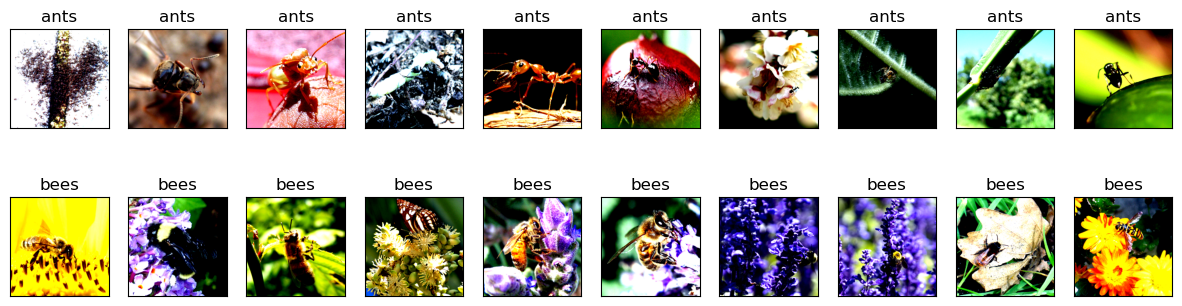

In [22]:
plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = val_dataset[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1) / 2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = val_dataset[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1) / 2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### DataLoader

In [23]:
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### model

In [24]:
# 事前学習済みモデルの読み込み
model = models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')
# 2クラス分類に変更
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
# structureの確認
model.parameters

<bound method Module.parameters of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine

In [25]:
# 事前学習済みモデルの読み込み
#weights = models.EfficientNet_B1_Weights.IMAGENET1K_V1
#efficientnet = models.efficientnet_b1(weights=weights)
# 2クラス分類用に出力サイズを2に変更
#efficientnet.classifier = nn.Linear(1280, 2)
# structureの確認
#efficientnet.parameters

### 学習

In [26]:
# 学習率
lr = 0.001
# 損失関数
criterion = nn.CrossEntropyLoss()
# 最適化関数
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# epoch数
num_epochs = 10

In [27]:
train_losses, val_losses, val_accuracies = utils.learn(model, train_loader, val_loader, optimizer=optimizer, loss_func=criterion, num_epoch=10)

Training:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0: train error: 0.6276767265796661, validation error: 0.4412009995430708, validation accuracy: 0.9187499918043613


epoch: 1: train error: 0.41423906445503234, validation error: 0.2936679236590862, validation accuracy: 0.9437499940395355


epoch: 2: train error: 0.30847528755664827, validation error: 0.2151363539742306, validation accuracy: 0.9437499940395355


epoch: 3: train error: 0.29264245331287386, validation error: 0.17009075422538444, validation accuracy: 0.9624999947845936


epoch: 4: train error: 0.24699533462524415, validation error: 0.14872003044001758, validation accuracy: 0.9624999910593033


epoch: 5: train error: 0.17489896833896637, validation error: 0.13138136835186742, validation accuracy: 0.9562499932944775


epoch: 6: train error: 0.17601432725787164, validation error: 0.1242262169107562, validation accuracy: 0.9624999910593033


epoch: 7: train error: 0.19237957075238227, validation error: 0.12713346145756077, validation accuracy: 0.9624999910593033


epoch: 8: train error: 0.2170416085422039, validation error: 0.11692896110616857, validation accuracy: 0.9812499955296516


epoch: 9: train error: 0.21906930655241014, validation error: 0.12261667277198285, validation accuracy: 0.9499999918043613


In [57]:
torch.save(model.state_dict(), 'model.pth')

In [58]:
val_accuracies

[0.9187499918043613,
 0.9437499940395355,
 0.9437499940395355,
 0.9624999947845936,
 0.9624999910593033,
 0.9562499932944775,
 0.9624999910593033,
 0.9624999910593033,
 0.9812499955296516,
 0.9499999918043613]

### Learning Rate Scheduler

In [ ]:
# 学習率のスケジューラ設定
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# デバイスの設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# モデルの訓練
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 各エポックに対して訓練と検証を実施
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに設定
            else:
                model.eval()   # モデルを評価モードに設定

            running_loss = 0.0
            running_corrects = 0

            # データをバッチごとにループ
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # パラメータの勾配をゼロにリセット
                optimizer.zero_grad()

                # 順伝播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 訓練時のみバックプロパゲーションとオプティマイズを実行
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 損失と正解数の統計を更新
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # モデルのベストパフォーマンスを保持
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # ベストモデルの重みをロード
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

# モデルの保存
torch.save(model.state_dict(), 'efficientnetv2_best_model.pth')

### Grad-CAM

In [52]:
model._modules.keys()

odict_keys(['features', 'avgpool', 'classifier'])

(7, 7)


/var/folders/ym/nfrz7f9d08s3_jg0qw6h_l6h0000gn/T/ipykernel_16407/2513027879.py:47: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  activation_map = Image.fromarray(activation_map).resize(image.size()[2:], Image.ANTIALIAS)


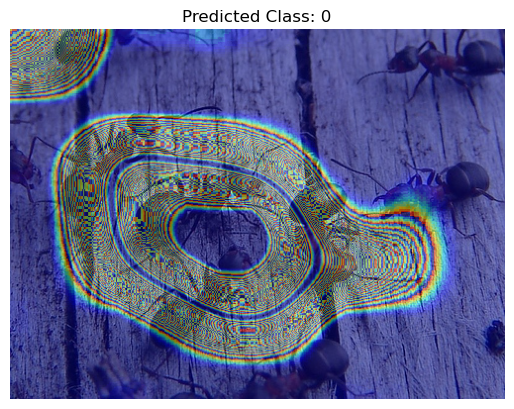

In [54]:
# 学習済みモデルの重みをロード
#model = torch.load('sample_model.pth')
#model.load_state_dict(torch.load('sample_model.pth', map_location=device))
#model.load_state_dict(torch.load('efficientnetv2_best_model.pth', map_location=device))
model.eval()  # 評価モードに設定

# 前処理の設定
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 入力画像の前処理関数
def process_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0)  # バッチサイズを1にする
    return image

# Grad-CAMの設定
target_layer = model.features[-1]  # 最後の特徴層を指定
cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)  # 最後の特徴層を指定

# 入力画像のパス（ここを実際の画像ファイルに置き換えてください）
#image_path = fr'/Users/hisashi/Desktop/git-hub/deep-learning/hymenoptera_data/train/ants/9715481_b3cb4114ff.jpg'
image_path = "/Users/hisashi/Desktop/git-hub/deep-learning/hymenoptera_data/train/ants/150801171_cd86f17ed8.jpg"
image = process_image(image_path)

# 予測の実行
model.zero_grad()
outputs = model(image)
_, pred_class = torch.max(outputs, 1)

# Grad-CAMの適用
activation_map = cam_extractor(pred_class.item(), outputs)[0]
# activation_mapをPILのImageに変換
activation_map = activation_map[0].cpu().detach().numpy()
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())  # 正規化
# activation_mapの形状を確認
print(activation_map.shape)  # (1, H, W) の形状になっているはず
# (H, W)の形状に変換
activation_map = np.uint8(activation_map * 255)
activation_map = np.squeeze(activation_map)  # (H, W) の形状にする

# PIL Imageに変換
activation_map = Image.fromarray(activation_map).resize(image.size()[2:], Image.ANTIALIAS)

# オーバーレイ
result = overlay_mask(Image.open(image_path), activation_map, alpha=0.5)

# 可視化
plt.imshow(result)
plt.title(f'Predicted Class: {pred_class.item()}')
plt.axis('off')
plt.show()

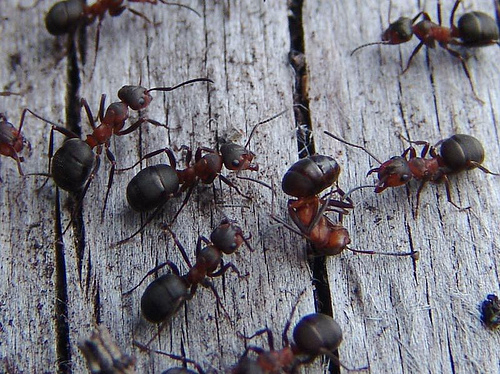

In [55]:
Image.open(image_path)

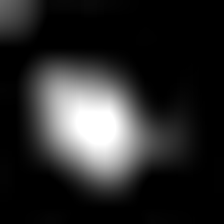

In [56]:
activation_map

### Grad-CAM(スクラッチ実装)

In [ ]:
# デバイスの設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 学習済みモデルのロード
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2クラス分類
model = model.to(device)

# 学習済みモデルの重みをロード
model.load_state_dict(torch.load('efficientnetv2_best_model.pth', map_location=device))
model.eval()  # 評価モードに設定

# 前処理の設定
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 入力画像の前処理関数
def process_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0)  # バッチサイズを1にする
    return image

# フォワードフックとバックワードフック
features = None
gradients = None

def save_features(module, input, output):
    global features
    features = output

def save_gradients(module, input, output):
    global gradients
    gradients = output[0]

# 最後の特徴層にフックを登録
model.features[-1].register_forward_hook(save_features)
model.features[-1].register_backward_hook(save_gradients)

# 入力画像のパス（ここを実際の画像ファイルに置き換えてください）
image_path = 'path_to_your_image.jpg'
image = process_image(image_path).to(device)

# 予測の実行
model.zero_grad()
outputs = model(image)
_, pred_class = torch.max(outputs, 1)

# 逆伝播
outputs[0, pred_class].backward()

# 勾配と特徴マップの取得
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
features = features[0]

# 重み付けした特徴マップの集計
for i in range(features.shape[0]):
    features[i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(features, dim=0).cpu().detach().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# ヒートマップを元画像に重ねる
img = Image.open(image_path)
heatmap = np.uint8(255 * heatmap)
heatmap = Image.fromarray(heatmap).resize(img.size, Image.ANTIALIAS)
heatmap = np.array(heatmap)
heatmap = np.uint8(255 * heatmap / heatmap.max())
heatmap = Image.fromarray(heatmap)
heatmap = heatmap.convert("RGBA")
img = img.convert("RGBA")
heatmap = heatmap.resize(img.size)

# オーバーレイ
blended = Image.blend(img, heatmap, alpha=0.5)

# 可視化
plt.imshow(blended)
plt.title(f'Predicted Class: {pred_class.item()}')
plt.axis('off')
plt.show()

In [ ]:
# pixel値の確認

# 画像を読み込む
image = Image.open('path_to_image.png')

# NumPy配列に変換
image_array = np.array(image)

# 画像の形状を確認
print(image_array.shape)  # (1024, 1024, 3)のような形状が返るはず

# 各チャンネルが同じか確認
if np.array_equal(image_array[:,:,0], image_array[:,:,1]) and np.array_equal(image_array[:,:,1], image_array[:,:,2]):
    print("各チャンネルは同じ値を持っています")
else:
    print("各チャンネルは異なる値を持っています")

# グレースケール画像に変換
grayscale_image = image.convert('L')

# グレースケール画像を保存
grayscale_image.save('path_to_grayscale_image.png')